In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
data = pd.read_csv('/content/Final.csv')

In [ ]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,03-01-2010,1.4413,1.4324,1.4484,1.4257,NaN,0.61%
1,10-01-2010,1.4385,1.4433,1.4585,1.4338,NaN,-0.19%
2,17-01-2010,1.4138,1.4339,1.4414,1.4026,NaN,-1.72%
3,24-01-2010,1.3864,1.4160,1.4198,1.3861,NaN,-1.94%
4,31-01-2010,1.3664,1.3864,1.4028,1.3586,NaN,-1.44%


In [ ]:
#converting the dataype of 'Date' col to 'datetime'
data['Date'] = pd.to_datetime(data['Date'],format='%d-%m-%Y')

In [ ]:
data.set_index('Date', inplace = True)

In [ ]:
data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2010-01-03,1.4413,1.4324,1.4484,1.4257,NaN,0.61%
2010-01-10,1.4385,1.4433,1.4585,1.4338,NaN,-0.19%
2010-01-17,1.4138,1.4339,1.4414,1.4026,NaN,-1.72%
2010-01-24,1.3864,1.4160,1.4198,1.3861,NaN,-1.94%
2010-01-31,1.3664,1.3864,1.4028,1.3586,NaN,-1.44%


In [ ]:
data = data.drop(columns=['Vol.' , 'Change %'])

In [ ]:
data.sort_index(inplace=True)

In [ ]:
data.head()

,Price,Open,High,Low
Date,,,,
2010-01-03,1.4413,1.4324,1.4484,1.4257
2010-01-10,1.4385,1.4433,1.4585,1.4338
2010-01-17,1.4138,1.4339,1.4414,1.4026
2010-01-24,1.3864,1.4160,1.4198,1.3861
2010-01-31,1.3664,1.3864,1.4028,1.3586


In [ ]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(data[data.columns])

In [ ]:
scaled_data = pd.DataFrame(scaled_values, columns = data.columns, index = data.index)

In [ ]:
scaled_data.head()

,Price,Open,High,Low
Date,,,,
2010-01-03,0.923905,0.902643,0.910951,0.952016
2010-01-10,0.918427,0.923824,0.930631,0.968347
2010-01-17,0.870110,0.905558,0.897311,0.905444
2010-01-24,0.816510,0.870773,0.855222,0.872177
2010-01-31,0.777387,0.813253,0.822097,0.816734


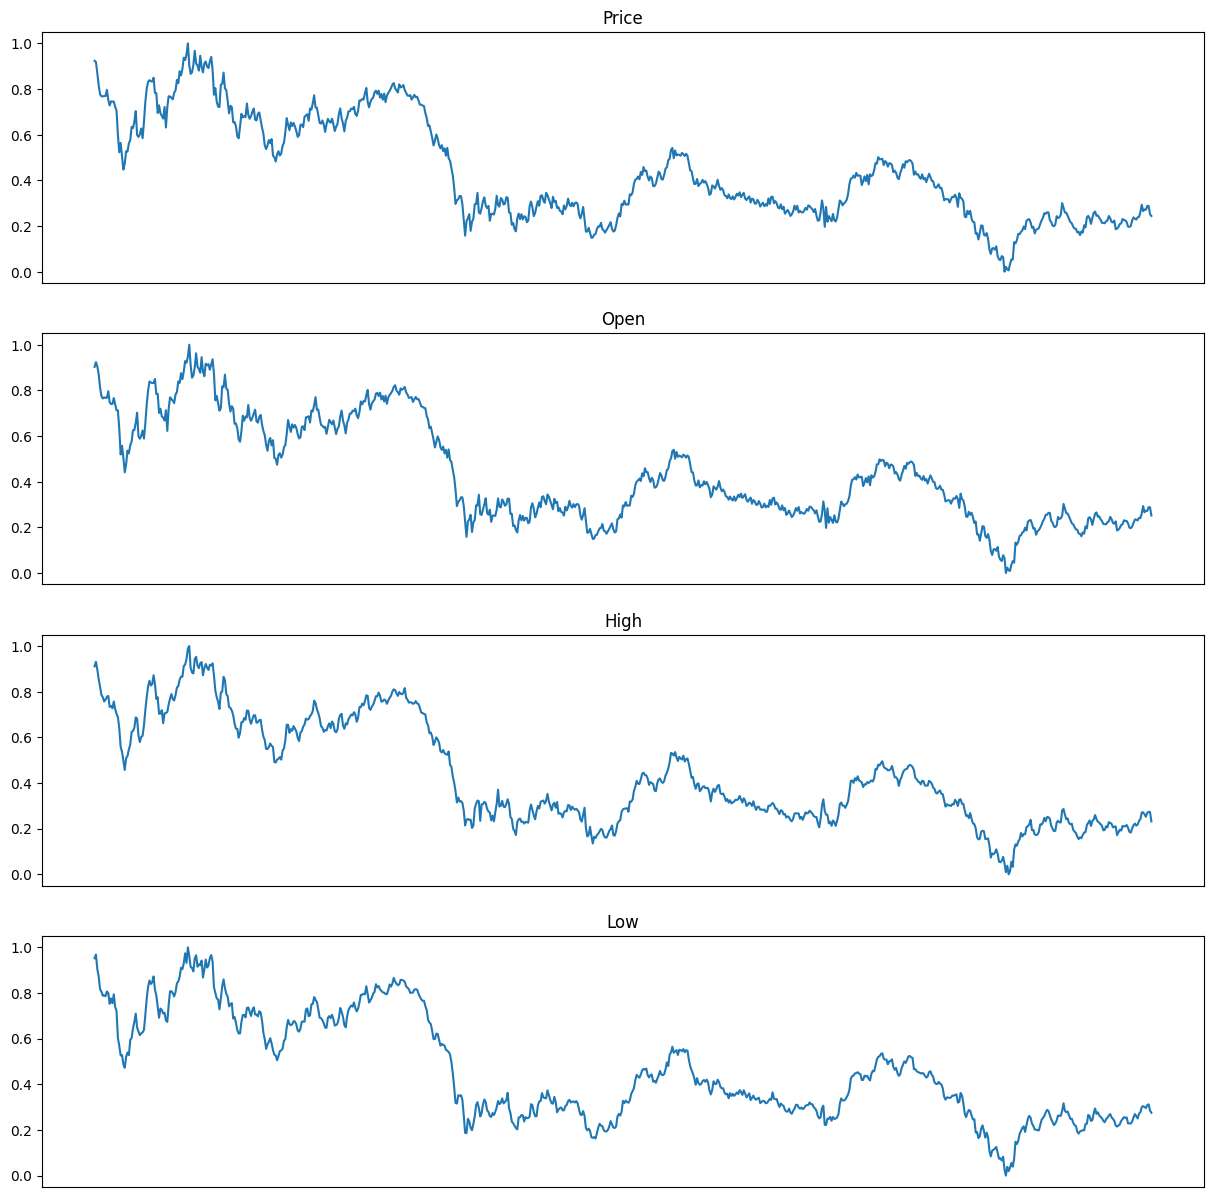

In [ ]:
plt.rcParams['figure.figsize'] = (15, 15)
figure, axes = plt.subplots(4)

for ax, col in zip(axes, scaled_data.columns):
  ax.plot(scaled_data[col])
  ax.set_title(col)
  ax.axes.xaxis.set_visible(False)

In [ ]:

window_size = 60

def create_sequence(data, window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i].values)
    return np.array(X), np.array(y)

X, y = create_sequence(scaled_data, window_size)

In [ ]:
X.shape , y.shape

((711, 60, 4), (711, 4))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((568, 60, 4), (568, 4), (143, 60, 4), (143, 4))

In [ ]:
model = keras.Sequential([
    # Adding the first LSTM layer with Dropout
    keras.layers.LSTM(units = 100, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.2),

    # Adding the second LSTM layer with Dropout
    keras.layers.LSTM(units = 100, return_sequences=True),
    keras.layers.Dropout(0.2),

    # Adding the third LSTM layer with Dropout
    keras.layers.LSTM(units = 100, return_sequences=False),
    keras.layers.Dropout(0.2),

    # Adding a Dense output layer
    keras.layers.Dense(y_train.shape[1])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer = 'adam',
              loss = 'mean_squared_error',
              metrics = ['RootMeanSquaredError'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

In [ ]:

history = model.fit(X_train, y_train,
                    validation_split = 0.2,
                    epochs=100,
                    batch_size=3,
                    callbacks=[early_stopping])

Epoch 1/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - RootMeanSquaredError: 0.1875 - loss: 0.0407 - val_RootMeanSquaredError: 0.0699 - val_loss: 0.0049
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - RootMeanSquaredError: 0.0796 - loss: 0.0064 - val_RootMeanSquaredError: 0.1209 - val_loss: 0.0146
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - RootMeanSquaredError: 0.0827 - loss: 0.0069 - val_RootMeanSquaredError: 0.0564 - val_loss: 0.0032
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - RootMeanSquaredError: 0.0718 - loss: 0.0052 - val_RootMeanSquaredError: 0.0541 - val_loss: 0.0029
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - RootMeanSquaredError: 0.0678 - loss: 0.0046 - val_RootMeanSquaredError: 0.0704 - val_loss: 0.0050
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - RootMeanSquaredError: 0.0796 - loss: 0.0064 - val_RootMeanSquaredError: 0.0475 - val_loss: 0.0023
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - RootMeanSqua

In [ ]:
predictions = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


In [ ]:
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

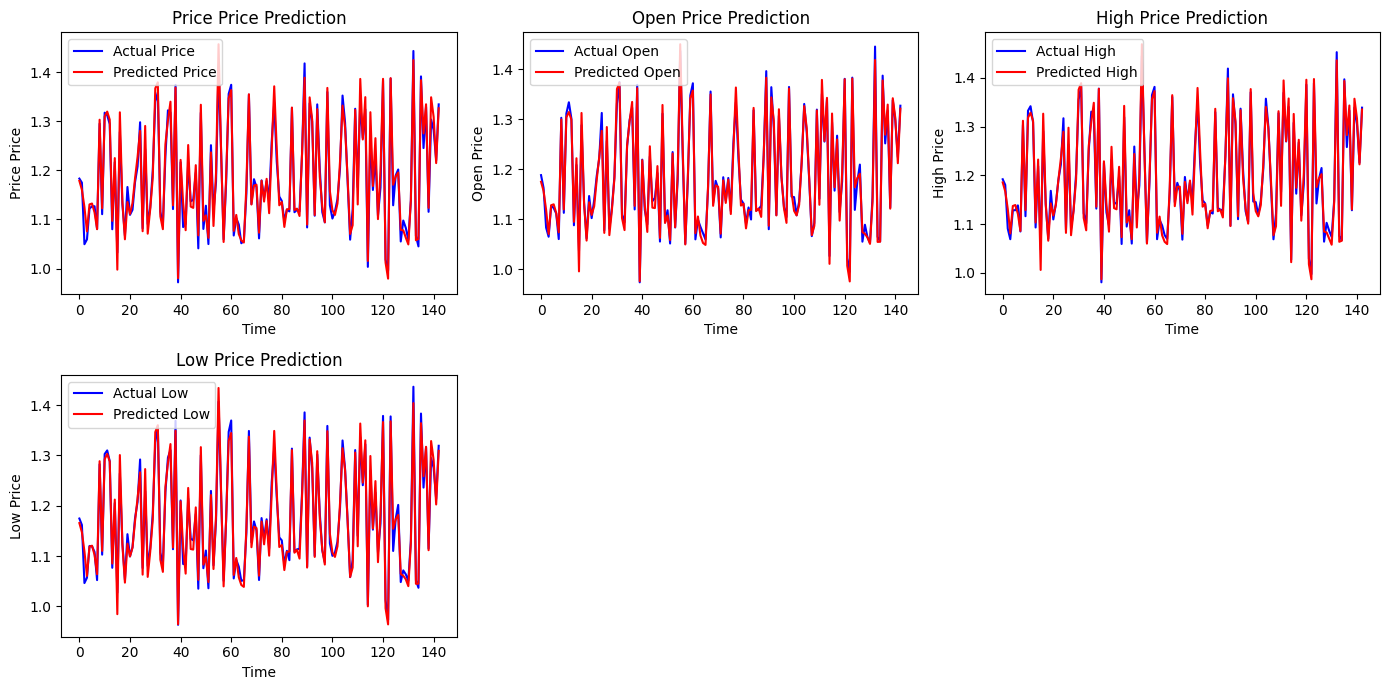

In [ ]:
plt.figure(figsize=(14, 7))

for i, col in enumerate(scaled_data.columns):
    plt.subplot(2, 3, i + 1)
    plt.plot(y_test_rescaled[:, i], color='blue', label=f'Actual {col}')
    plt.plot(predictions[:, i], color='red', label=f'Predicted {col}')
    plt.title(f'{col} Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{col} Price')
    plt.legend()

plt.tight_layout()

In [ ]:
# Get the last window of data from the scaled dataset
last_window = scaled_data[-window_size:].values

# Reshape the last window to match the input shape of the model
last_window = last_window.reshape(1, window_size, scaled_data.shape[1])

# Make a prediction using the model
predicted_scaled_values = model.predict(last_window)

# Inverse transform the prediction to get the original scale
predicted_values = scaler.inverse_transform(predicted_scaled_values)

# Print the predicted values
print("Next predicted value:", predicted_values[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Next predicted value: [1.1046112 1.1021355 1.1110324 1.0927464]


In [ ]:
print("Last actual value:", y_test_rescaled[-1])
print("Last predicted value:", predictions[-1])

Last actual value: [1.3344 1.3272 1.3386 1.3191]
Last predicted value: [1.3264922 1.3212315 1.3348275 1.3090618]


In [ ]:

from sklearn.metrics import mean_squared_error
import math

rmse = math.sqrt(mean_squared_error(y_test_rescaled, predictions))
print("RMSE:", rmse)

RMSE: 0.016077137309617344


In [ ]:
# prompt: Download the model as pickle file
import pickle

# Save the model as a pickle file
with open('stock_prediction_model.pkl', 'wb') as f:
    pickle.dump(model, f)

from google.colab import files
files.download('stock_prediction_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>